## Numerical and analytical steady state calculations for the overdamped DLD model

In this jupyter notebook, we employ numerical calculations to evaluate the following:

* the steady-state of a generalized Fokker Planck master equation (ME): the overdamped DLD model: 
    - Brownian particle is subjected to a stochastic Gaussian and non-Gaussian noises.   
<br>    
* the equilibrium state of the standard Fokker-Planck equation (sBM): 
    - Brownian particle is subjected to a stochastic Gaussian noise.

We also perform a comparison between these numerical results and the analytical solution obtained in the reference: . We compute the ME derivatives using finite diference method. 

In [1]:
import numpy as np
import time as tm 
import pylab as plt

from scipy import integrate
from scipy import sparse
plt.rcParams.update({'font.size': 16})

### Definitions and Parameters

* Parameters
* Coeficients of the standard Fokker-Planck equation and of the DLD master equation

In [2]:
# Parameters value
dx = 1.0                     # spatial separation
x = np.arange(-80,80, dx)    # spatial grid points

m     = 1.0                  # mass
omega = 0.5 #0.001           # HO frequency
gamma = 10.0                 # dissip    
KbT   = gamma/2                 
Dif   = 2*KbT/gamma          # D= nu/gamma^2 = 2KbT/gamma diffusion const
sigma = 0.6 * gamma          

varsigma = sigma/gamma

# Master equation coefficients
beta1 = 1
beta2 = (1/2) * varsigma**2
beta3 = (1/8) * varsigma**4
beta4 = (1/48) * varsigma**6
beta5 = (1/384) * varsigma**8

zeta1 = 1/2 
zeta2 = (1/8) * varsigma**2
zeta3 = (1/48) * varsigma**4
zeta4 = (1/384) * varsigma**6
zeta5 = (1/3840) * varsigma**8

C1 = (gamma*varsigma**2/Dif) * beta1 + zeta1
C2 = (gamma*varsigma**2/Dif) * beta2 + zeta2
C3 = (gamma*varsigma**2/Dif) * beta3 + zeta3
C4 = (gamma*varsigma**2/Dif) * beta4 + zeta4
C5 = (gamma*varsigma**2/Dif) * beta5 + zeta5

# Definition of analytical function for the BM
kappa = gamma * Dif/omega**2

Z = 1./(np.sqrt(2*np.pi*kappa * np.abs(- zeta1)))
brow_an = Z * (np.exp(- x**2/(kappa)))

### analytical steady state for DLD model (Gaussian + non-Gaussian features)
x0 = - x/(kappa*C1)
D1 =  + (C1)
D2 =  + 3*(C2) * (x0)**2 + 5*(C3) * (x0)**4
E1 =  + (C4/4) * (x0)**4 + (C5/6) * (x0)**6
Q2 = + D1 + D2 

# analytical equilibrium distribution (Gaussian)
Den = 1/np.sqrt(2*np.pi*kappa * np.abs(Q2))
GenBM_an = Den  * (np.exp(- x**2/(2*D1*kappa))) * np.exp(kappa * (E1))

### The master equation formulation

A ME is formulated for two distinct models:

* For the standard Fokker-Planck equation: standard Brownian motion (sBM),  
* For the overdamped DLD model: generalized BM (gBM).
    
In both cases, we consider the initial distribution denoted as $\rho_0(x)$. 

1.0


<Figure size 640x480 with 0 Axes>

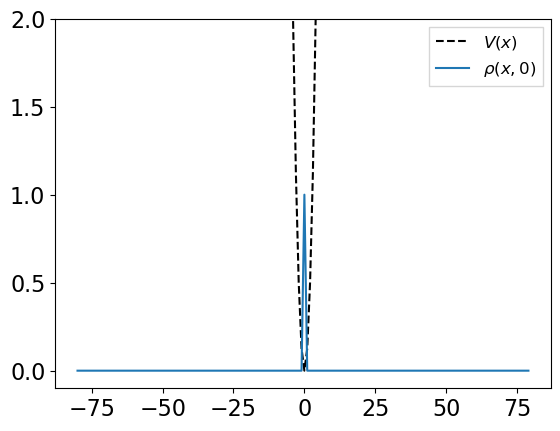

<Figure size 640x480 with 0 Axes>

In [3]:
# Initial rho0   
def ddf(x,sig):
    x0 = x #- 10
    val = np.zeros_like(x0)
    val[(-(1/(10*sig))<=x0) & (x0<=(1/(10*sig)))] = 1
    return val

delta0 = ddf(x,1)            # initial delta
print(np.trapz(delta0, x))   # normalization-check


# overdamped sBM rho_t   
def BM_rho_t(t, rho):
    B0 = omega**2/gamma * np.convolve(x*rho, [1,-1], 'same') / dx  
    B2 = 1/2 * np.convolve(rho, [1,-2,1], 'same') / (dx**2)
    #print(t)
    return  B0 + Dif* B2 

# overdamped DLD rho_t   
def GenBM_rho_t(t, rho):
    D0 = omega**2/gamma * np.convolve(x*rho, [1,-1], 'same') / dx  
    D1 = C1 * np.convolve(rho, [1,-2,1], 'same') / (dx**2)
    D2 = C2 * np.convolve(rho, [1, -4, 6, -4, 1], 'same') / (dx**4)
    D3 = C3 * np.convolve(rho, [1, -6, 15, -20, 15,  -6, 1], 'same') / (dx**6)
    D4 = C4 * np.convolve(rho, [1, -8, 28, -56, 70, -56, 28, -8, 1], 'same') / (dx**8)
    D5 = C5 * np.convolve(rho, [1, -10, 45, -120, 210, -252, 210, -120, 45, -10, 1], 'same') / (dx**10)
    return  D0 + Dif*(D1 + D2 + D3 + D4 + D5)


# Harmonic Force and Potential    
V = 0.5 * omega**2 * (x)**2    # harmonic potential
F = - omega**2 * (x)           # harmonic force

# Plotting rho0 and V
plt.plot(x, V, "k--", label=r"$V(x)$")           # plot potential
plt.plot(x, delta0, label=r"$\rho(x,0)$")        # plot rho0
plt.ylim(-0.1, 2)
plt.legend(loc=1, fontsize=12, fancybox=False)
plt.figure()

### Master equation solutions 

In [4]:
# Time initial conditions
dt = 0.1                       # time interval for snapshots
t0 = 0.0                       # initial time
tf = 100.0                     # final time
t_eval = np.arange(t0, tf, dt) # time range

for i in t_eval:
    t_dur = int(i/dt)
    
start = tm.time()

################## Solving MEs ##################

# overdamped standard BM
BM_sol = integrate.solve_ivp(BM_rho_t, t_span=[t0, tf], y0=delta0, t_eval=t_eval,  method="RK23")

# overdamped generalized BM
GenBM_sol = integrate.solve_ivp(GenBM_rho_t, t_span=[t0, tf], y0=delta0, t_eval=t_eval,  method="RK23")

print(GenBM_sol.message)
#################################################

end = tm.time()
print("")
print(end-start)

The solver successfully reached the end of the integration interval.

0.054075002670288086


### Plot of the numerical and analytical results of sBM eq. state 

* analytical: $\rho_{sBM}^{an}(x) $ 
* numerical: $\rho_{sBM}(x) $ 

<Figure size 640x480 with 0 Axes>

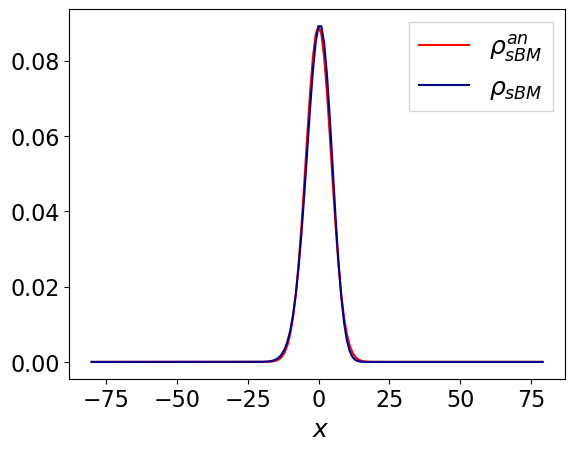

<Figure size 640x480 with 0 Axes>

In [5]:
plt.plot(x, brow_an , color='red', label=r"$ \rho_{sBM}^{an} $")
plt.plot(x, BM_sol.y[:,t_dur], color= 'darkblue', label=r"$ \rho_{sBM} $")
plt.xlabel(r' $x$', fontsize = 18)
plt.legend(loc=1, fontsize=18, fancybox=False)
plt.figure()

### Plot of the numerical result of:

* gBM steady-state: $\rho_{gBM}(x)$ 
* sBm equilibrium state: $\rho_{sBM}(x) $

We compare then the analytical and numerical solutions for the $\rho_{gBM}^{an}(x)$ distribution.

<Figure size 640x480 with 0 Axes>

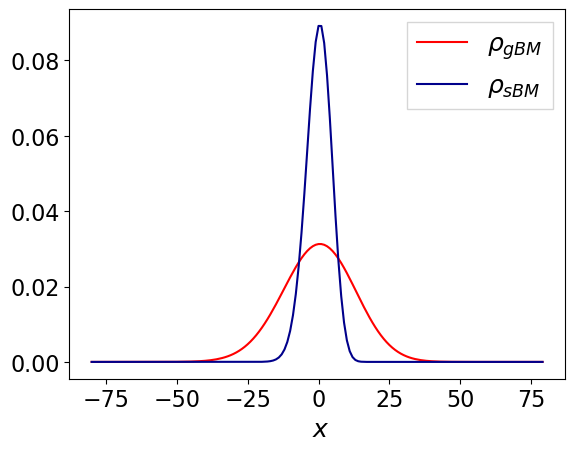

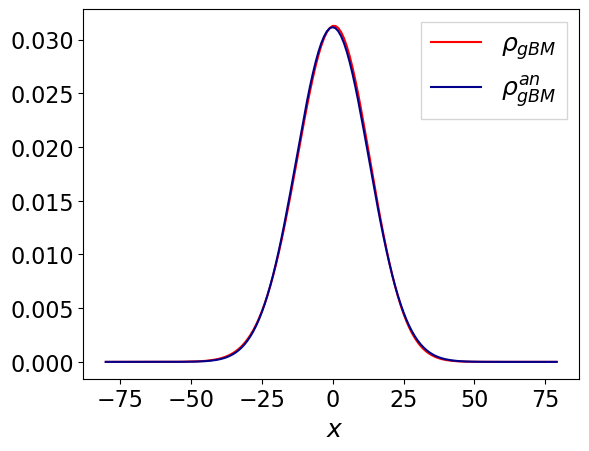

<Figure size 640x480 with 0 Axes>

In [6]:
plt.plot(x, GenBM_sol.y[:,t_dur], color='red', label=r"$\rho_{gBM}$")
plt.plot(x, BM_sol.y[:,t_dur], color= 'darkblue', label=r"$\rho_{sBM}$")
plt.xlabel(r' $x$', fontsize = 18)
plt.legend(loc=1, fontsize=18, fancybox=False)
plt.figure()

# Plot of the numerical and analytical gBMs
plt.plot(x, GenBM_sol.y[:,t_dur], color='red', label=r"$\rho_{gBM}$")
plt.plot(x, GenBM_an, color= 'darkblue', label=r"$\rho_{gBM}^{an}$")
plt.xlabel(r' $x$', fontsize = 18)
plt.legend(loc=1, fontsize=18, fancybox=False)
plt.figure()
